In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

# Data

In [2]:
import seaborn as sns
data = sns.load_dataset('iris')
df = torch.tensor(data.drop(columns="species").values).float()
labels = torch.zeros(len(df), dtype=torch.long)
labels[data.species == 'versicolor'] = 1 
labels[data.species == 'virginica'] = 2

In [3]:
x_train, x_test, y_train, y_test = train_test_split(df, labels, train_size=0.7)
tf_train = TensorDataset(x_train, y_train)
tf_test = TensorDataset(x_test, y_test)
train = DataLoader(tf_train, batch_size=16, shuffle=True)
test = DataLoader(tf_test, batch_size=tf_test.tensors[0].shape[0])

In [4]:
tf_train.tensors[0][:10]

tensor([[6.3000, 2.5000, 5.0000, 1.9000],
        [5.1000, 2.5000, 3.0000, 1.1000],
        [5.5000, 3.5000, 1.3000, 0.2000],
        [6.2000, 2.9000, 4.3000, 1.3000],
        [6.7000, 3.1000, 4.4000, 1.4000],
        [5.2000, 2.7000, 3.9000, 1.4000],
        [6.0000, 2.2000, 4.0000, 1.0000],
        [5.8000, 2.8000, 5.1000, 2.4000],
        [6.4000, 3.1000, 5.5000, 1.8000],
        [5.7000, 3.0000, 4.2000, 1.2000]])

In [5]:
tf_train.tensors[1][:10]

tensor([2, 1, 0, 1, 1, 1, 1, 2, 2, 1])

In [6]:
for x,y in train:
    print(x.shape, y.shape)

torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([9, 4]) torch.Size([9])


In [7]:
for x,y in test:
    print(x.shape, y.shape)

torch.Size([45, 4]) torch.Size([45])


In [9]:
def model():
    ann = nn.Sequential(
        nn.Linear(4, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64,3)
    )
    lossfn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ann.parameters(), lr=0.005)
    return ann, lossfn, optimizer

In [10]:
ann, lossfn, optimizer = model()

In [11]:
print(ann)

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)


In [18]:
for i in ann.named_parameters():
    print(i[0], i[1].shape, i[1].numel())

0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


In [26]:
nweights = 0
for i, j in ann.named_parameters():
    if 'bias' not in i:
        nweights = nweights + j.numel()
        print(i, nweights)

0.weight 256
2.weight 4352
4.weight 4544


For L1 regularization we need to access the weights directly 

In [29]:
numepochs = 1000
def train_model(l1lambda):    
    trainacc = []
    testacc = []
    losses = []
    nweights = 0
    # count the weights of the parameters that are not bias
    for i, j in ann.named_parameters():
        if 'bias' not in i:
            nweights = nweights + j.numel()
    # training
    for i in range(numepochs):
        batchloss = []
        batchacc = []
        # batch training
        for x, y in train:
            yhat = ann(x)
            loss = lossfn(yhat, y)
            # add l1 term
            l1term = torch.tensor(0.,requires_grad=True)
            for pname, weight in ann.named_parameters():
                if 'bias' not in pname:
                    l1term = l1term + torch.sum(torch.abs(weight))
            loss = loss + l1lambda + l1term/nweights
            # compute gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batchacc.append(100*torch.mean((torch.argmax(yhat, axis=1)== y).float()).item())
            batchloss.append(loss.item())
        trainacc.append(np.mean(batchacc))
        losses.append(np.mean(batchloss))
        testx, testy = next(iter(test)) 
        pred = torch.argmax(ann(testx), axis=1)
        testacc.append(100*torch.mean((pred==testy).float()).item())
    return trainacc, testacc, losses

In [30]:
trainacc, testacc, losses = train_model(0.1)

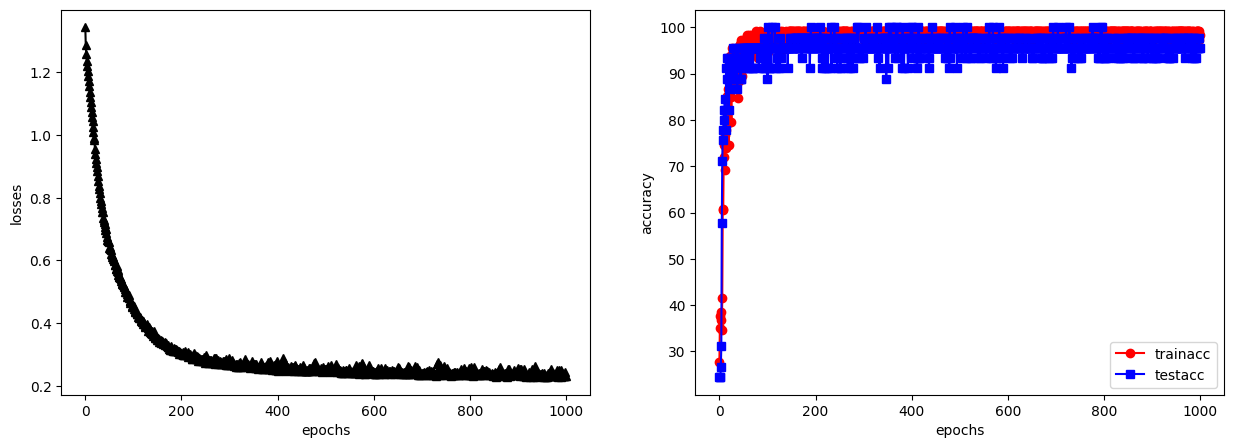

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(losses,'k^-')
ax[0].set_ylabel("losses")
ax[0].set_xlabel("epochs")
ax[1].plot(trainacc, "ro-")
ax[1].plot(testacc, "bs-")
ax[1].set_ylabel("accuracy")
ax[1].set_xlabel("epochs")
ax[1].legend(['trainacc', 'testacc'])

# Experiment

In [32]:
lambdas = np.linspace(0, 0.005, 10)
numepochs = 1000

In [33]:
trainaccmatrix = np.zeros((len(lambdas), numepochs))
testaccmatrix = np.zeros((len(lambdas), numepochs))

In [35]:
for i in range(len(lambdas)):
    ann, lossfn, optimizer = model()
    trainaccmatrix[i:], testaccmatrix[i:], _ = train_model(lambdas[i]) 

In [36]:
trainaccmatrix

array([[36.90476205, 37.5992064 , 37.5992064 , ..., 99.10714286,
        99.10714286, 99.10714286],
       [42.55952409, 47.2222226 , 47.42063497, ..., 99.10714286,
        98.21428571, 99.10714286],
       [30.65476205, 40.27777783, 57.24206354, ..., 99.10714286,
        98.21428571, 99.10714286],
       ...,
       [31.74603177, 46.72619062, 69.34523838, ..., 99.10714286,
        99.10714286, 99.10714286],
       [30.65476205, 25.69444446, 21.9246032 , ..., 99.10714286,
        99.10714286, 99.10714286],
       [29.26587303, 32.73809552, 29.26587303, ..., 99.10714286,
        99.10714286, 98.21428571]])

In [37]:
testaccmatrix

array([[24.44444448, 24.44444448, 24.44444448, ..., 95.55555582,
        95.55555582, 95.55555582],
       [57.77778029, 53.33333611, 60.00000238, ..., 97.77777791,
        95.55555582, 97.77777791],
       [40.0000006 , 73.33333492, 84.44444537, ..., 95.55555582,
        95.55555582, 95.55555582],
       ...,
       [35.55555642, 60.00000238, 91.11111164, ..., 95.55555582,
        95.55555582, 95.55555582],
       [40.0000006 ,  6.66666701, 24.44444448, ..., 97.77777791,
        95.55555582, 95.55555582],
       [40.0000006 , 40.0000006 , 68.88889074, ..., 95.55555582,
        95.55555582, 97.77777791]])